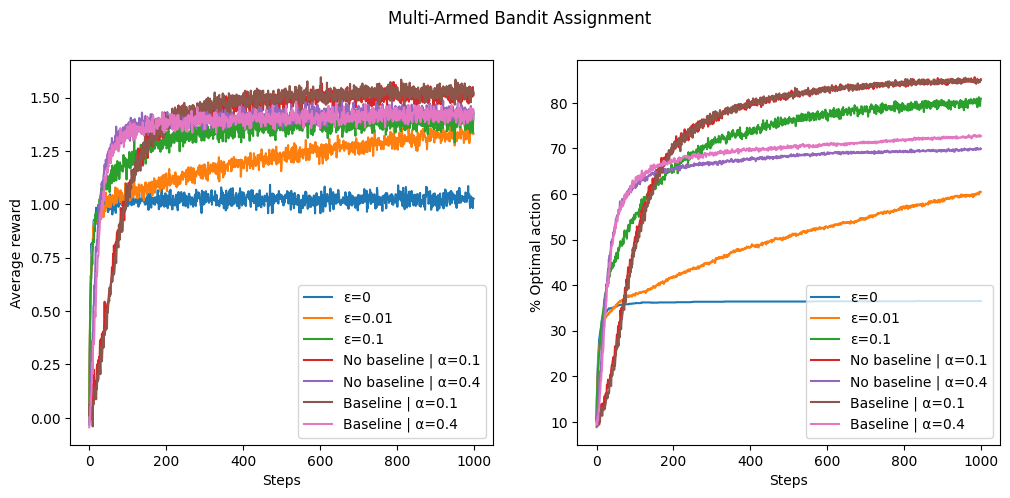

In [7]:

import numpy as np
import matplotlib.pyplot as plt


class Bandit:
    def __init__(self, k=10):
        self.k = k
        self.q_true = np.random.normal(0, 1, k)
        self.optimal_action = np.argmax(self.q_true)

    def pull(self, action):

        return np.random.normal(self.q_true[action], 1)


class EpsilonGreedyAgent:
    def __init__(self, k=10, epsilon=0.1):
        self.k = k
        self.epsilon = epsilon
        self.Q = np.zeros(k)
        self.N = np.zeros(k)

    def select_action(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.k)
        return np.argmax(self.Q)

    def update(self, action, reward):
        self.N[action] += 1
        self.Q[action] += (reward - self.Q[action]) / self.N[action]


class GradientBanditAgent:
    def __init__(self, k=10, alpha=0.1, use_baseline=False):
        self.k = k
        self.alpha = alpha
        self.use_baseline = use_baseline
        self.H = np.zeros(k)
        self.time = 0
        self.avg_reward = 0

    def action_probs(self):
        exp_H = np.exp(self.H - np.max(self.H))
        return exp_H / np.sum(exp_H)

    def select_action(self):
        probs = self.action_probs()
        return np.random.choice(self.k, p=probs)

    def update(self, action, reward):
        self.time += 1
        if self.use_baseline:
            self.avg_reward += (reward - self.avg_reward) / self.time
            baseline = self.avg_reward
        else:
            baseline = 0.0

        probs = self.action_probs()
        one_hot = np.zeros(self.k)
        one_hot[action] = 1
        self.H += self.alpha * (reward - baseline) * (one_hot - probs)


def run(agent_class, runs=2000, steps=1000, **agent_params):
    rewards = np.zeros((runs, steps))
    optimal_actions = np.zeros((runs, steps))

    for run in range(runs):
        bandit = Bandit()
        agent = agent_class(k=bandit.k, **agent_params)

        for step in range(steps):
            action = agent.select_action()
            reward = bandit.pull(action)
            agent.update(action, reward)

            rewards[run, step] = reward
            if action == bandit.optimal_action:
                optimal_actions[run, step] = 1

    return rewards.mean(axis=0), optimal_actions.mean(axis=0)


def main():
    steps = 1000
    runs = 2000

    results = {}


    for eps in [0, 0.01, 0.1]:
        avg_r, opt_a = run(EpsilonGreedyAgent, runs=runs, steps=steps, epsilon=eps)
        results[f"ε={eps}"] = (avg_r, opt_a)


    configs = [
        (False, 0.1),
        (False, 0.4),
        (True, 0.1),
        (True, 0.4)
    ]
    for use_baseline, alpha in configs:
        label = f"{'Baseline' if use_baseline else 'No baseline'} | α={alpha}"
        avg_r, opt_a = run(GradientBanditAgent, runs=runs, steps=steps,
                           alpha=alpha, use_baseline=use_baseline)
        results[label] = (avg_r, opt_a)


    plt.figure(figsize=(12, 5))


    plt.subplot(1, 2, 1)
    for label, (avg_r, _) in results.items():
        plt.plot(avg_r, label=label)
    plt.xlabel("Steps")
    plt.ylabel("Average reward")
    plt.legend()


    plt.subplot(1, 2, 2)
    for label, (_, opt_a) in results.items():
        plt.plot(opt_a * 100, label=label)
    plt.xlabel("Steps")
    plt.ylabel("% Optimal action")
    plt.legend()

    plt.suptitle("Multi-Armed Bandit Assignment")
    plt.show()

if __name__ == "__main__":
    main()
